In [1]:
from DiagnosisAI.lightining_modules.binary_slices_segment import BinarySegmenterUnet
from pathlib import Path
import torch.nn as nn
import torch as t
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from DiagnosisAI.datasets_torch.brain_slices_dataset import BrainSlicesDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from DiagnosisAI.utils.metrics import calc_metrics, calculate_type_errors
from torchmetrics import JaccardIndex

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pl_model = BinarySegmenterUnet()
path = "../datasets/brain/train_images_max_area/"
checkpoint_path = "./checkpoints/binary_segment_unet/resnet34/"
model_state_path = "./model_states/binary_segment_unet/resnet34/"
batch_size = 8
num_workers = 4
train_size = 0.7
seed = 42

In [4]:
def __get_filenames_from_dir__(path:str):
    filenames_pickle = []
    for dir in Path(path).iterdir():
        for filename in dir.iterdir():
            rel_path = Path(*filename.parts[-2:])
            filenames_pickle.append(rel_path)

    return filenames_pickle

In [5]:
print("Getting filenames ...")
test_size = 1 - train_size
filenames = __get_filenames_from_dir__(path)
train_names, val_names = train_test_split(filenames, test_size=test_size, random_state=seed)
val_names, test_names = train_test_split(val_names, test_size=0.5, random_state=seed)

Getting filenames ...


In [6]:
train_dataset = BrainSlicesDataset(train_names)
val_dataset = BrainSlicesDataset(val_names)
test_dataset = BrainSlicesDataset(test_names)

In [7]:
pl_model.load_state_dict(t.load('../trainings/model_states/binary_segment_unet/resnet34/checkpoint.ckpt'))

<All keys matched successfully>

test model on dataset and eval metrics

In [133]:
global_acc = 0.0
global_prec = 0.0
global_f1score = 0.0
global_recall = 0.0
global_ji = 0.0

pl_model.eval()
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = pl_model(img.unsqueeze(0))
    output = nn.Sigmoid()(output)
    output = t.where(output >= 0.5, 1, output)

    tp, fp, tn, fn = calculate_type_errors(output, label, mode='segment_binary')
    recall, precision, acc, f1_score = calc_metrics(tp, fp, tn, fn)
    ji = JaccardIndex(num_classes=2)(output, label.type(t.int32).unsqueeze(0)).item()
    global_ji += ji
    global_acc += acc
    global_prec += precision
    global_f1score += f1_score
    global_recall += recall

print(f"Acc: {global_acc / (i+1)}, Recall: {global_recall / (i+1)}, F1score: {global_f1score / (i+1)}, Precision: {global_prec / (i+1)}, IoU: {global_ji / (i+1)}")

100%|██████████| 188/188 [02:42<00:00,  1.16it/s]

Acc: 0.9959938526153564, Recall: 0.9145854115486145, F1score: 0.9344592690467834, Precision: 0.9603967070579529, IoU: 0.9403920577878647



ekstrakcja cech

In [8]:
temp_network = pl_model.network
temp_network = temp_network.encoder
temp_network.eval()

ResNetEncoder(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [9]:
embeddings = []
t1ce_images = []
labels = []
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = temp_network(img.unsqueeze(0))
        output = output[-1]
        output = nn.AdaptiveAvgPool2d(output_size=(1, 1))(output)
        output = output.squeeze().numpy()
        output = output.reshape(1, -1)

    t1ce_images.append(img[3].numpy())
    labels.append(label.numpy())
    embeddings.append(output)
    del output
embeddings = np.array(embeddings)
embeddings = embeddings.squeeze()

100%|██████████| 188/188 [02:32<00:00,  1.23it/s]


/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.002s...
[t-SNE] Computed neighbors for 188 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 2.086015
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.604454
[t-SNE] KL divergence after 750 iterations: 0.270707


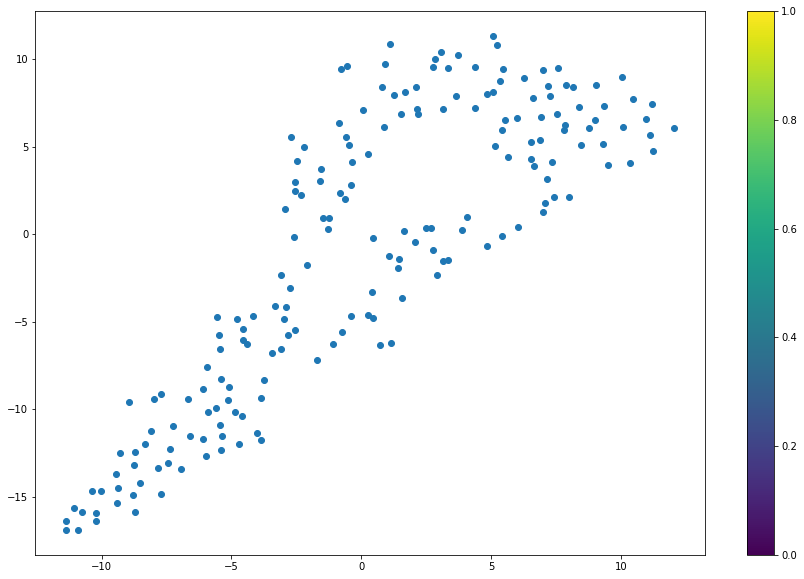

In [319]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

In [328]:
neighbors = NearestNeighbors(n_neighbors=len(embeddings), algorithm='brute', metric='euclidean').fit(embeddings)
distances, indices = neighbors.kneighbors([embeddings[3]])
indices = indices.flatten()

k_nearest = indices[5:10]
nearest_dist = distances.flatten()[0:5]
k_furthest = indices[-5:][::-1]
furthest_dist = distances.flatten()[-5:][::-1]

In [329]:
k_nearest

array([  3,  39, 104, 111,  98])

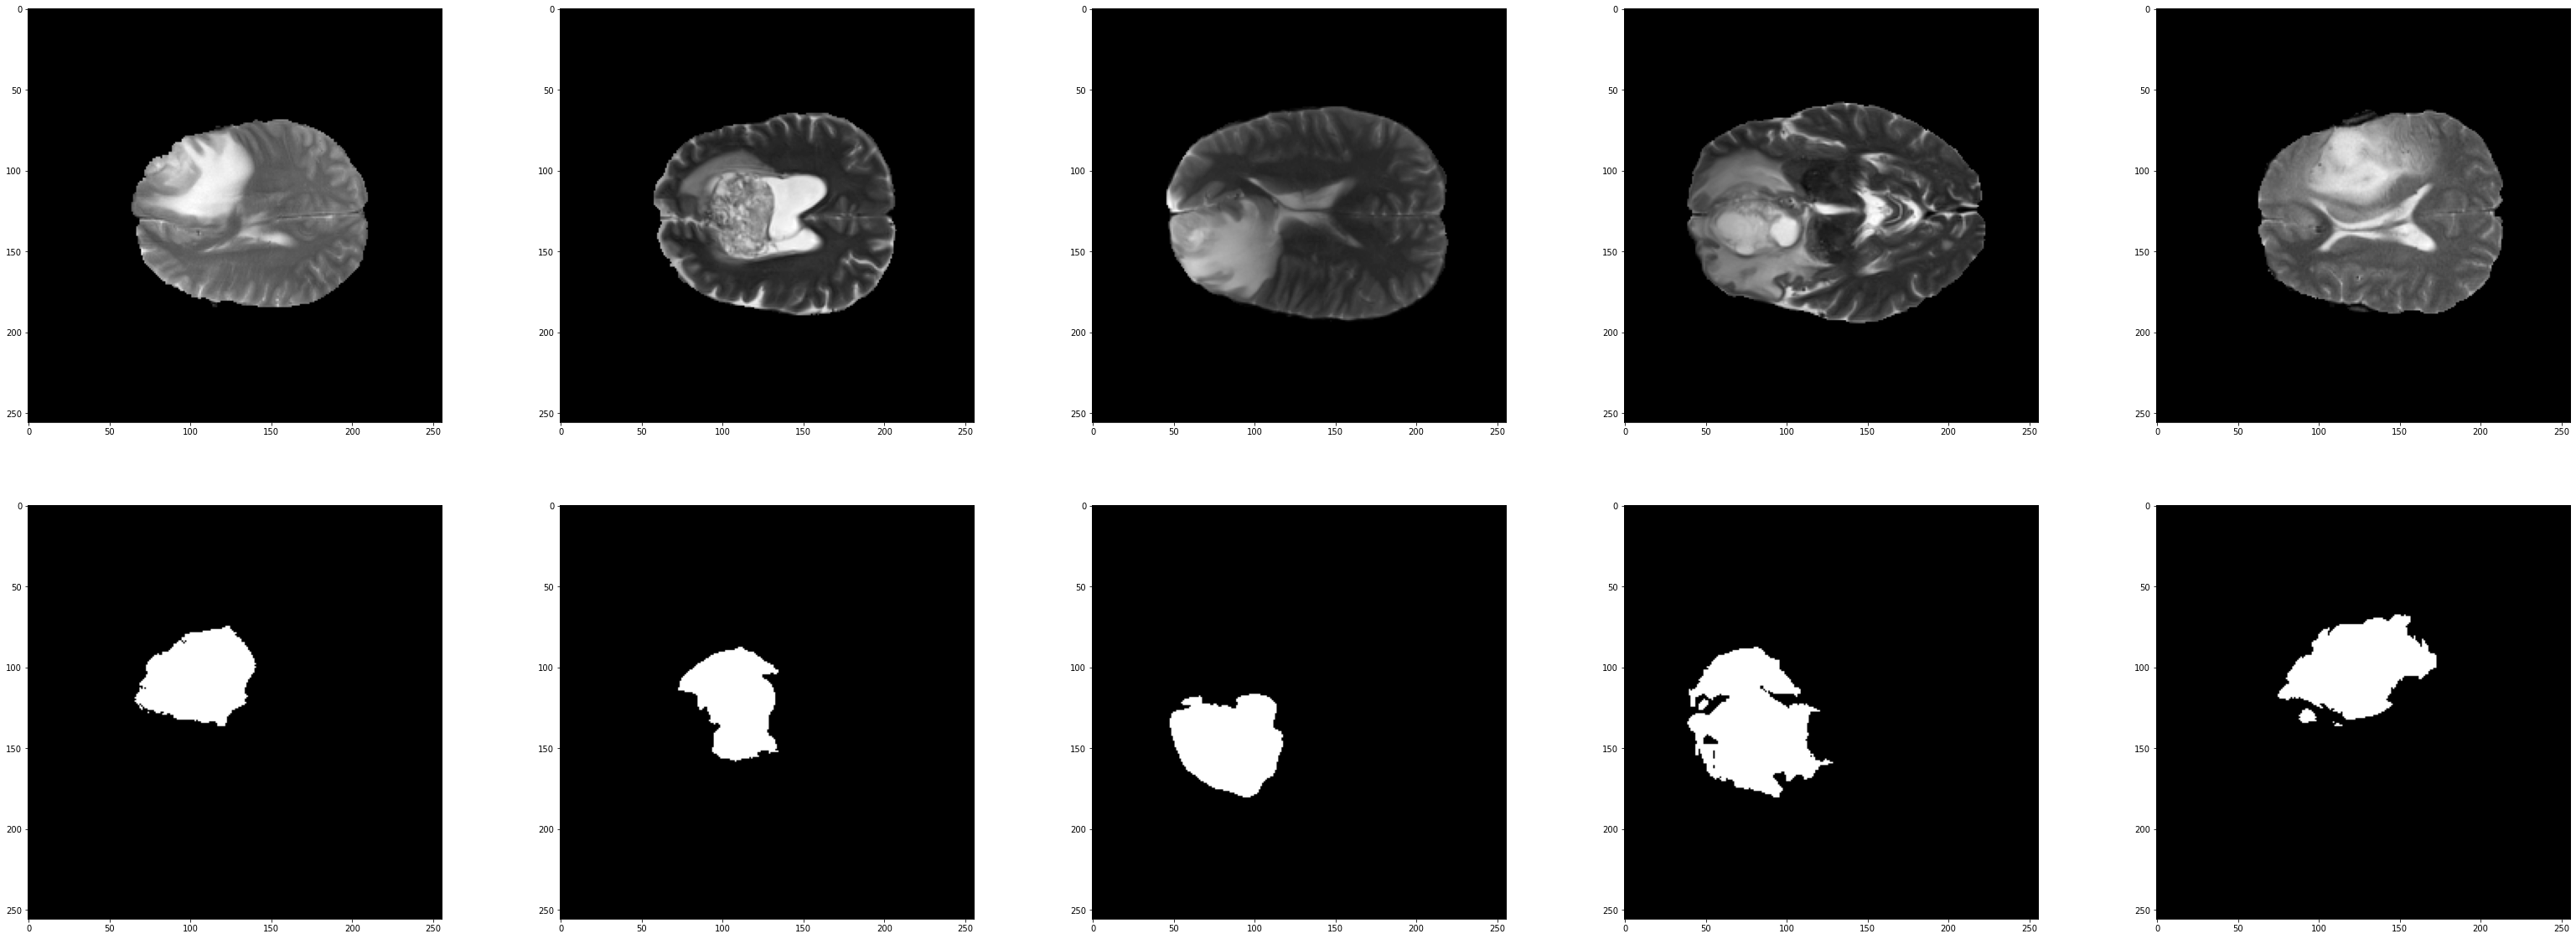

In [334]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(55, 20))
for i, idx in enumerate(k_nearest):
    ax[0, i].imshow(t1ce_images[idx], cmap='gray')
    ax[1, i].imshow(labels[idx][0], cmap='gray')

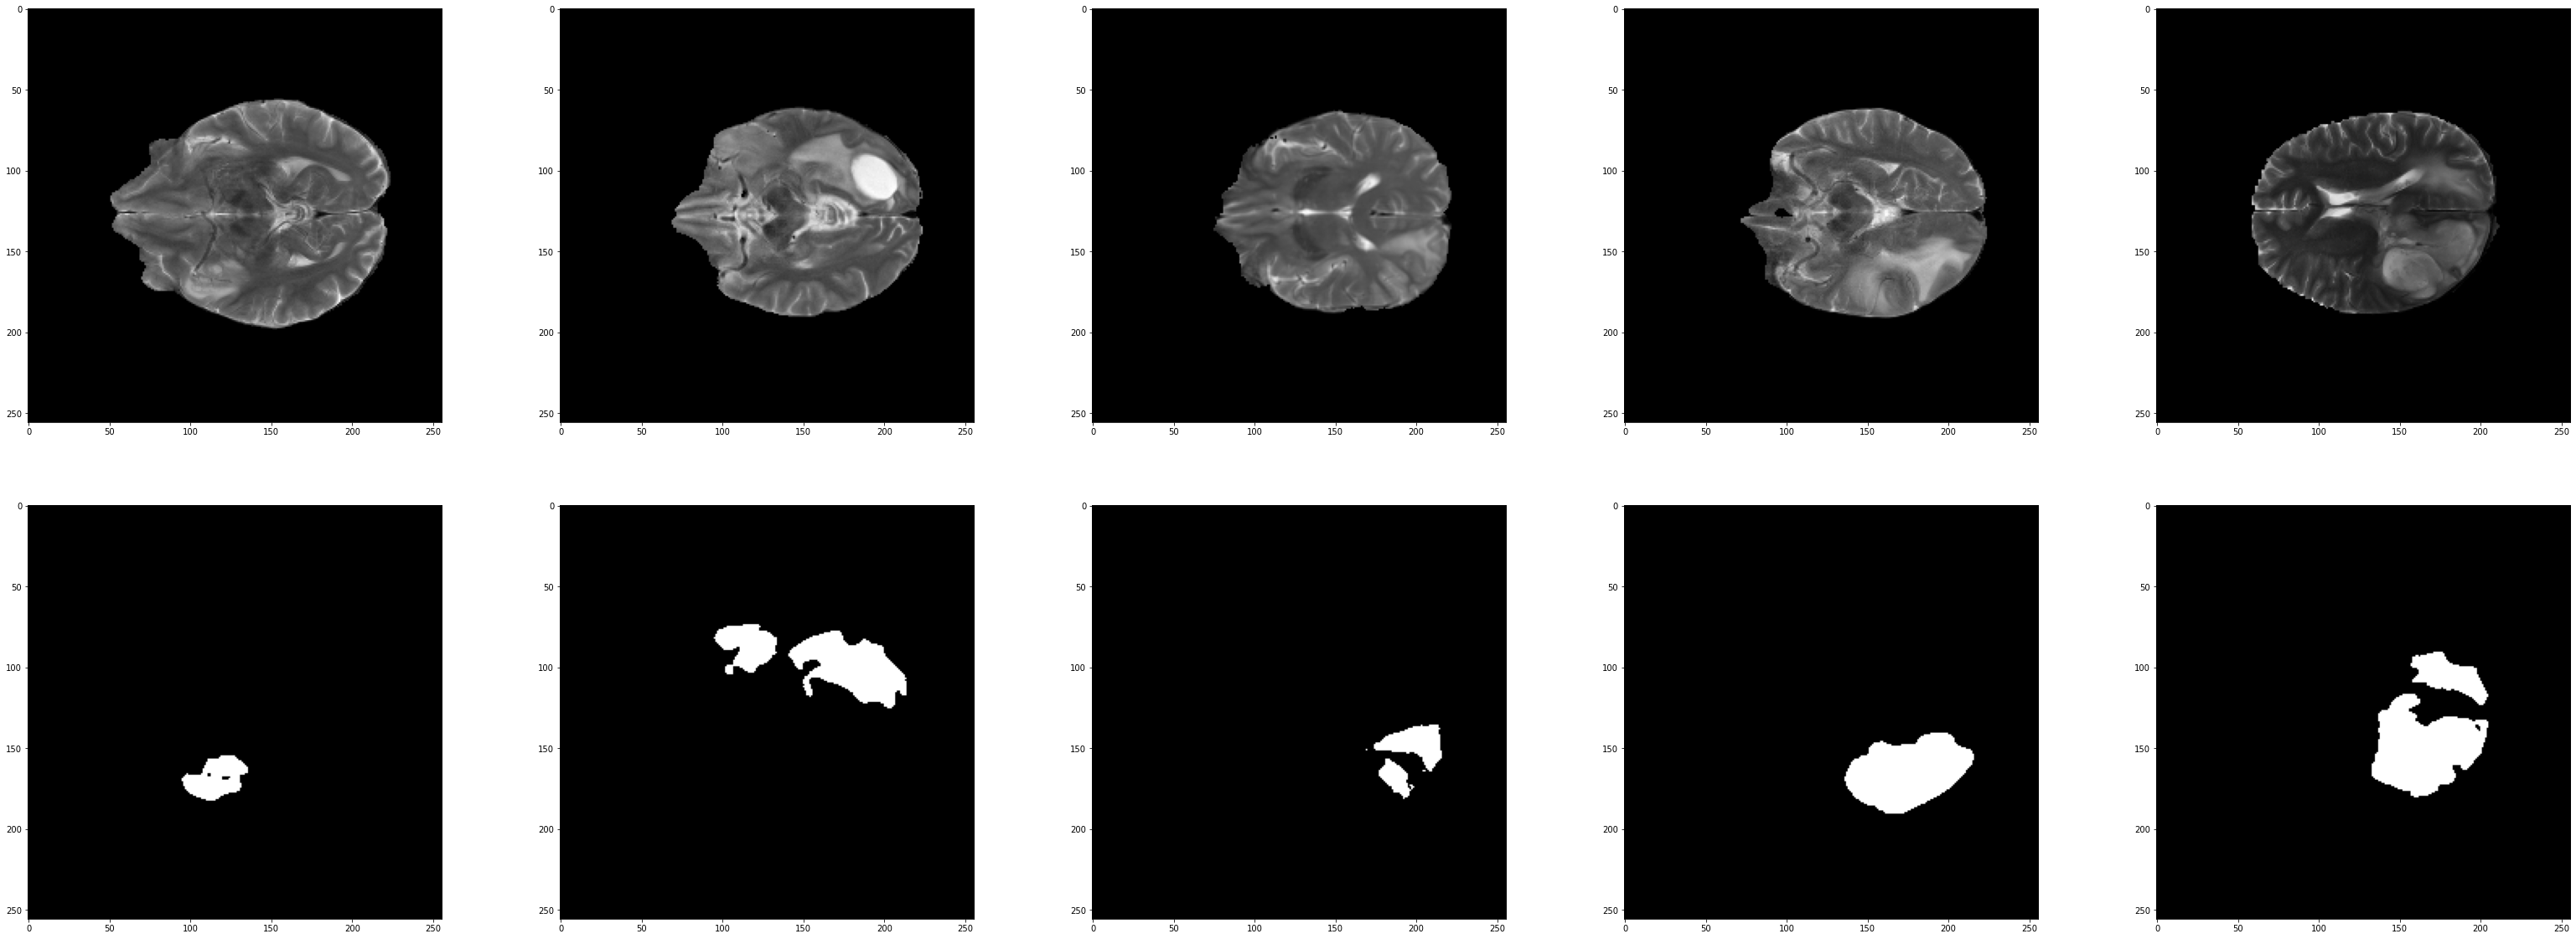

In [335]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(55, 20))
for i, idx in enumerate(k_furthest):
    ax[0, i].imshow(t1ce_images[idx], cmap='gray')
    ax[1, i].imshow(labels[idx][0], cmap='gray')